We originally thought donor `NMS22-289343` was actually `NW-001` but apparently this was due to a misunderstanding. Changing the mentions of the name "NW001"

In [1]:
library('tidyverse')
library('ggrepel')
library('ggbeeswarm')
library('readxl')
library('limma')
library('edgeR')

org_opts <- options()

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
exp_matrix <-
    read_xlsx('counts raw chondrosarcoma.xlsx', sheet='TargetCountMatrix')

exp_matrix %>%
    head()

TargetName,NMS23-471 | 001 | S100B,NMS23-471 | 002 | S100B,NMS23-471 | 003 | S100B,NMS23-471 | 004 | S100B,NMS23-471 | 005 | CD68,NMS23-471 | 005 | CD3,NMS23-471 | 006 | CD68,NMS23-471 | 006 | CD3,NMS23-471 | 007 | CD68,⋯,S10-479 | 013 | CD3,S10-479 | 013 | S100,S10-479 | 014 | CD68,S10-479 | 014 | CD3,S10-479 | 014 | S100,S10-479 | 015 | CD68,S10-479 | 015 | CD3,S10-479 | 015 | S100,S10-479 | 016 | CD68,S10-479 | 016 | CD3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RFC3,1.245731,1.741101,1.319508,1.148698,1,1.000000,1,1,1.000000,⋯,1.000000,2.701920,1.000000,1,1.245731,1.319508,1.245731,1.000000,1.430969,1.888175
PSMB5,2.047673,1.148698,1.888175,1.245731,1,1.319508,1,1,1.000000,⋯,1.148698,2.605171,1.643752,1,1.430969,1.000000,1.000000,1.430969,1.643752,1.148698
POLD4,1.741101,1.000000,1.430969,1.515717,1,1.245731,1,1,1.000000,⋯,1.319508,4.324246,1.148698,1,1.782602,1.319508,1.319508,1.000000,1.430969,1.245731
MAP3K8,1.430969,1.245731,1.430969,1.000000,1,1.000000,1,1,1.000000,⋯,1.000000,2.701920,1.430969,1,2.111786,1.319508,1.000000,1.430969,1.319508,1.000000
IRF9,1.515717,1.148698,1.888175,1.148698,1,1.000000,1,1,1.148698,⋯,1.430969,4.042823,1.148698,1,1.741101,1.148698,1.148698,1.430969,1.000000,1.430969
PAX3,1.643752,1.148698,1.000000,1.515717,1,1.000000,1,1,1.000000,⋯,1.245731,3.758480,1.000000,1,2.352158,1.000000,1.148698,1.148698,1.148698,1.245731


In [3]:
tumor_vs_peritumor <-
    read_xlsx('normalized raw chondrosarcoma.xlsx', sheet='TargetCountMatrix', n_max=1, col_names=paste('c', 1:141, sep='_')) %>%
    t()

tumor_vs_peritumor %>%
    head()

c_1,tumor
c_2,tumor
c_3,tumor
c_4,tumor
c_5,peritumor
c_6,peritumor


In [4]:
sample_annotations <-
    tibble(
        `sample_desc`=exp_matrix %>% select(-`TargetName`) %>% colnames(),
        `region_type`=tumor_vs_peritumor %>% as.vector()
    ) %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

sample_annotations %>%
    head()

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS23-471 | 001 | S100B,NMS23-471,001,S100B,tumor
NMS23-471 | 002 | S100B,NMS23-471,002,S100B,tumor
NMS23-471 | 003 | S100B,NMS23-471,003,S100B,tumor
NMS23-471 | 004 | S100B,NMS23-471,004,S100B,tumor
NMS23-471 | 005 | CD68,NMS23-471,005,CD68,peritumor
NMS23-471 | 005 | CD3,NMS23-471,005,CD3,peritumor


In [5]:
exp_tbl <-
    exp_matrix %>%
    pivot_longer(
        names_to='sample_desc',
        values_to='norm_exp',
        -`TargetName`
    ) %>%
    left_join(sample_annotations, by='sample_desc') %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    relocate(`region_type`, .after=`region_id`) %>%
    rename(`gene_symbol`=`TargetName`) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

exp_tbl %>%
    head()

gene_symbol,sample_desc,sample_name,region_id,region_type,marker,norm_exp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
RFC3,NMS23-471 | 001 | S100B,NMS23-471,001,tumor,S100B,1.245731
RFC3,NMS23-471 | 002 | S100B,NMS23-471,002,tumor,S100B,1.741101
RFC3,NMS23-471 | 003 | S100B,NMS23-471,003,tumor,S100B,1.319508
RFC3,NMS23-471 | 004 | S100B,NMS23-471,004,tumor,S100B,1.148698
RFC3,NMS23-471 | 005 | CD68,NMS23-471,005,peritumor,CD68,1.000000
RFC3,NMS23-471 | 005 | CD3,NMS23-471,005,peritumor,CD3,1.000000


In [6]:
samples_of_interest <-
    sample_annotations %>%
    filter(
        `sample_name` == 'NMS22-289343'
    )

samples_of_interest

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS22-289343 | 001 | CD68,NMS22-289343,001,CD68,tumor
NMS22-289343 | 001 | CD3,NMS22-289343,001,CD3,tumor
NMS22-289343 | 001 | S100B,NMS22-289343,001,S100B,tumor
NMS22-289343 | 002 | CD68,NMS22-289343,002,CD68,tumor
NMS22-289343 | 002 | CD3,NMS22-289343,002,CD3,tumor
NMS22-289343 | 002 | S100B,NMS22-289343,002,S100B,tumor
NMS22-289343 | 003 | CD68,NMS22-289343,003,CD68,tumor
NMS22-289343 | 003 | CD3,NMS22-289343,003,CD3,tumor
NMS22-289343 | 003 | S100B,NMS22-289343,003,S100B,tumor


In [7]:
exp_matrix_dge <-
    exp_matrix %>%
    select(-`TargetName`) %>%
    select(all_of(samples_of_interest$`sample_desc`)) %>%
    as.matrix() %>%
    (function(x) {
        rownames(x) <- exp_matrix %>% select(`TargetName`) %>% pull
        
        x
    }) 

exp_matrix_dge

,NMS22-289343 | 001 | CD68,NMS22-289343 | 001 | CD3,NMS22-289343 | 001 | S100B,NMS22-289343 | 002 | CD68,NMS22-289343 | 002 | CD3,NMS22-289343 | 002 | S100B,NMS22-289343 | 003 | CD68,NMS22-289343 | 003 | CD3,NMS22-289343 | 003 | S100B,NMS22-289343 | 004 | S100B,⋯,NMS22-289343 | 014 | CD68,NMS22-289343 | 014 | CD3,NMS22-289343 | 015 | CD68,NMS22-289343 | 015 | CD3,NMS22-289343 | 016 | CD68,NMS22-289343 | 016 | CD3,NMS22-289343 | 017 | CD68,NMS22-289343 | 017 | CD3,NMS22-289343 | 018 | CD68,NMS22-289343 | 018 | CD3
RFC3,1.000000,1.245731,1.000000,1,1.000000,1.148698,1.000000,1,1.148698,1.148698,⋯,1.000000,1.148698,1.000000,1.148698,1.000000,1.000000,1,1.148698,1,1.000000
PSMB5,1.148698,1.000000,1.000000,1,1.000000,1.000000,1.000000,1,1.000000,1.319508,⋯,1.515717,1.000000,1.000000,1.000000,1.000000,1.245731,1,1.000000,1,1.000000
POLD4,1.148698,1.148698,1.148698,1,1.148698,1.643752,1.000000,1,2.267933,1.148698,⋯,1.000000,1.148698,1.000000,1.245731,1.000000,1.000000,1,1.319508,1,1.148698
MAP3K8,1.000000,1.000000,1.000000,1,1.000000,1.148698,1.148698,1,1.245731,1.245731,⋯,1.000000,1.000000,1.000000,1.148698,1.000000,1.000000,1,1.000000,1,1.148698
IRF9,1.000000,1.000000,1.000000,1,1.000000,1.515717,1.000000,1,1.245731,1.148698,⋯,1.000000,1.000000,1.148698,1.319508,1.000000,1.000000,1,1.379730,1,1.000000
PAX3,1.148698,1.000000,1.000000,1,1.000000,1.888175,1.000000,1,1.148698,1.245731,⋯,1.245731,1.148698,1.000000,1.148698,1.000000,1.000000,1,1.515717,1,1.148698
APOB,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1,1.000000,1.515717,⋯,1.000000,1.148698,1.000000,1.515717,1.000000,1.000000,1,1.000000,1,1.000000
RASGRP2,1.000000,1.000000,1.000000,1,1.000000,1.148698,1.000000,1,1.379730,1.319508,⋯,1.000000,1.000000,1.000000,1.245731,1.000000,1.000000,1,1.000000,1,1.000000
JAK2,1.000000,1.000000,1.000000,1,1.000000,1.148698,1.000000,1,1.000000,1.000000,⋯,1.000000,1.000000,1.000000,1.148698,1.000000,1.148698,1,1.000000,1,1.000000
PLA2G4E,1.000000,1.000000,1.000000,1,1.000000,1.148698,1.000000,1,1.319508,1.000000,⋯,1.000000,1.148698,1.000000,1.000000,1.000000,1.000000,1,1.000000,1,1.245731


In [8]:
exp_model <-
    samples_of_interest %>%
    model.matrix(data=., ~`region_type`)

exp_model

,(Intercept),region_typetumor
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1
10,1,1


In [9]:
dge <-
    DGEList(exp_matrix_dge) %>%
    calcNormFactors()

keep <- filterByExpr(dge, exp_model, min.count=.1)
dge <- dge[keep,, keep.lib.sizes=FALSE]
vdge <- voom(dge, exp_model)
all_fit <- lmFit(vdge, exp_model) %>% eBayes

In [10]:
all_table <-
    topTable(all_fit, adjust.method='bonferroni', n=nrow(exp_matrix_dge), sort.by='p') %>%
    rownames_to_column(var='gene') %>%
    as_tibble()

all_table %>%
    head(50)

Removing intercept from test coefficients



gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD74,-0.19484312,9.356454,-4.428260,5.511217e-05,0.1082954,1.054590
GPX1,-0.14452833,9.319976,-3.347328,1.597639e-03,1.0000000,-1.296324
SFRP4,-0.12462843,9.253786,-3.260165,2.056522e-03,1.0000000,-1.393886
TPI1,-0.11558821,9.266381,-3.221319,2.298962e-03,1.0000000,-1.486812
CD276,-0.10181932,9.274189,-3.120761,3.057950e-03,1.0000000,-1.717593
FLT3LG,-0.11523565,9.251505,-3.077517,3.452073e-03,1.0000000,-1.814316
BRIP1,-0.10189059,9.244122,-3.013214,4.127152e-03,1.0000000,-1.962277
CSF2RB,-0.16205793,9.361170,-2.840018,6.609281e-03,1.0000000,-2.470614
ACSF3,-0.07707789,9.257538,-2.762678,8.115475e-03,1.0000000,-2.520484


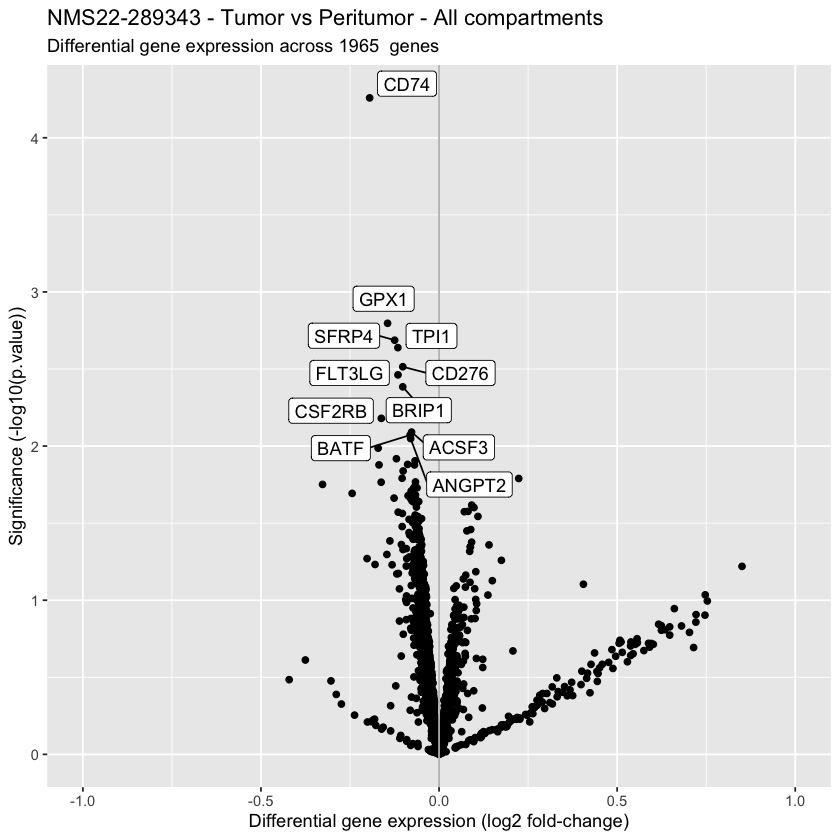

In [11]:
all_table %>%
    mutate(
        `label`=case_when(
            abs(`logFC`) >= 1 ~ str_replace_all(`gene`, ',.*', ''),
            -log10(`P.Value`) > 2 ~ str_replace_all(`gene`, ',.*', ''),
            -log10(`P.Value`) < 1 & `logFC` > 1 ~ str_replace_all(`gene`, ',.*', ''),
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='NMS22-289343 - Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes')
        ) +
        xlim(-1, 1)


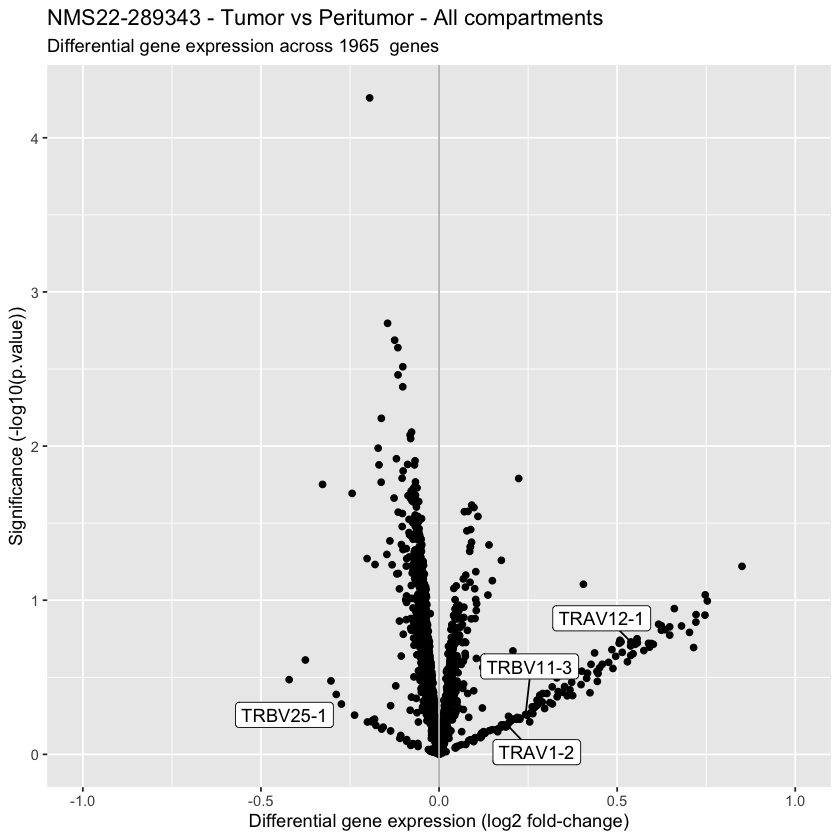

In [12]:
all_table %>%
    mutate(
        `label`=case_when(
            `gene` %in% c('TRBV25-1', 'TRBV11-3', 'TRAV1-2', 'TRAV12-1', 'TRAV14/DV4') ~ gene,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='NMS22-289343 - Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes')
        ) +
        xlim(-1, 1)